# <a name="0.0"></a>Содержание:
* [Описание проекта](#0.)
    - [Описание данных](#0.1.)
    - [Условия задачи](#0.2.)
* [Шаг 1. Открываем файл и изучаем общую информацию](#1.)
    - [Вывод](#1.1.)
* [Шаг 2. Обучаем и проверяем модель для каждого региона](#2.)
    - [Обучаем модель и генерируем прогнозы на валидационной выборке](#2.1.)
    - [Вычисляем средний запас сырья и RMSE](#2.2.)
    - [Вывод](#2.3.)
* [Шаг 3. Подготовка к расчёту прибыли](#3.)
    - [Сохраняем ключевые значения в константы](#3.1.)
    - [Рассчитываем точку безубыточности разработки новой скважины](#3.2.)
    - [Вывод](#3.3.)
* [Шаг 4. Расчёт прибыли и рисков](#4.)
* [Шаг 5. Общие выводы](#5.)

<a name="0."></a>
## Описание проекта
На основании данных, предоставленных нефтедобывающей компанией, необходимо решить, где бурить новую скважину. Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Определяют регион с максимальной суммарной прибылью отобранных скважин. Прибыль равна суммарной прибыли отобранных месторождений;

Для исследования предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль, а также проанализировать возможную прибыль и риски.
<br>
<font size="2">([к содержанию](#0.0))</font>

<a name="0.1."></a>
### Описание данных:
- id - уникальный идентификатор скважины
- f0, f1, f2 — три различных признака точек
- product  — объёмов запасов в скважине
<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="0.2."></a>
### Условия задачи:
- Для обучения модели использовать только линейную регрессию;
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
- Бюджет на разработку скважин в регионе — 10 млрд рублей;
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью;
<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="1."></a>
# Шаг 1. Открываем файл и изучаем общую информацию
<font size="2">([к содержанию](#0.0))</font> 

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
first_region = pd.read_csv('./datasets/geo_data_0.csv')
second_region = pd.read_csv('./datasets/geo_data_1.csv')
third_region = pd.read_csv('./datasets/geo_data_2.csv')

In [3]:
first_region.sample(5)

,id,f0,f1,f2,product
9014,RaXET,-0.906973,0.334004,6.726854,127.403080
40568,cFVyi,2.097900,0.582080,-2.557579,122.326752
64273,TUWw8,0.090943,1.135287,3.593231,130.630987
65826,WlV1k,0.571410,0.798031,6.379379,125.032120
96882,IPzVn,1.043609,0.203707,6.377485,119.812417


In [4]:
second_region.sample(5)

,id,f0,f1,f2,product
81012,Ww6bZ,-5.918290,-3.529772,3.997849,110.992147
55405,q83pK,10.915635,-14.312469,3.998904,107.813044
42151,ePMOH,-0.998103,5.201009,4.001336,107.813044
475,rnPzU,-6.923787,-15.791294,4.994400,137.945408
90261,wHA0u,5.567071,-7.568008,-0.002024,3.179103


In [5]:
third_region.sample(5)

,id,f0,f1,f2,product
99541,Kt8zw,1.724518,4.451981,3.936308,90.319699
99476,VBK4B,1.553845,0.405259,6.220077,111.501012
71183,GhPmm,-3.982554,-0.225910,1.316103,94.071701
55863,xbFk8,-1.795650,1.264251,5.248797,153.619916
58197,ob6oR,1.314560,0.181754,1.918757,109.752341


In [6]:
# Проверим id на уникальность, может есть скважины с коллизией в названии
regions = [list(first_region.id),
           list(second_region.id),
           list(third_region.id)]
# Для первого проверяем 2 и 3 регионы
def find_collision():
    for name in regions[0]:
        if name in regions[1]:
            print('Есть коллизия с именем (1<->2)', name)
        if name in regions[2]:
            print('Есть коллизия с именем (1<->3)', name)
    # Для второго только 3
    for name in regions[1]:
        if name in regions[2]:
            print('Есть коллизия с именем (2<->3)', name)

In [7]:
%%time
find_collision()

Есть коллизия с именем (1<->2) Q64YW
Есть коллизия с именем (1<->3) wqgPo
Есть коллизия с именем (1<->3) kpKGs
Есть коллизия с именем (1<->3) scFN4
Есть коллизия с именем (1<->3) i2csb
Есть коллизия с именем (1<->3) Suyut
Есть коллизия с именем (1<->3) uSye4
Есть коллизия с именем (1<->2) CXJ2r
Есть коллизия с именем (1<->3) 5ssQt
Есть коллизия с именем (1<->3) tgOl6
Есть коллизия с именем (1<->2) Y2udP
Есть коллизия с именем (1<->2) g3RRG
Есть коллизия с именем (1<->3) 2tyMi
Есть коллизия с именем (1<->3) TXPOv
Есть коллизия с именем (1<->3) G6k8A
Есть коллизия с именем (1<->3) rAJA6
Есть коллизия с именем (1<->3) PyNp5
Есть коллизия с именем (1<->2) mpZhE
Есть коллизия с именем (1<->3) LhkAh
Есть коллизия с именем (1<->2) L1Fdm
Есть коллизия с именем (1<->2) it2OW
Есть коллизия с именем (1<->3) eVdPR
Есть коллизия с именем (1<->2) gnA83
Есть коллизия с именем (1<->2) Mp3uM
Есть коллизия с именем (1<->3) H2jd8
Есть коллизия с именем (1<->3) lFHA5
Есть коллизия с именем (1<->2) pGQRI
Е

In [8]:
first_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
second_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
third_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
pd.merge(pd.merge(first_region.describe(),
                  second_region.describe(),
                  left_index=True, right_index=True,
                  suffixes=('', '_second')),
         third_region.describe(),
         left_index=True, right_index=True,
         suffixes=('', '_third')).T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347
f0_second,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1_second,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2_second,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product_second,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408
f0_third,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1_third,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801


---------------------------------------Изучаем Первый участок---------------------------------------


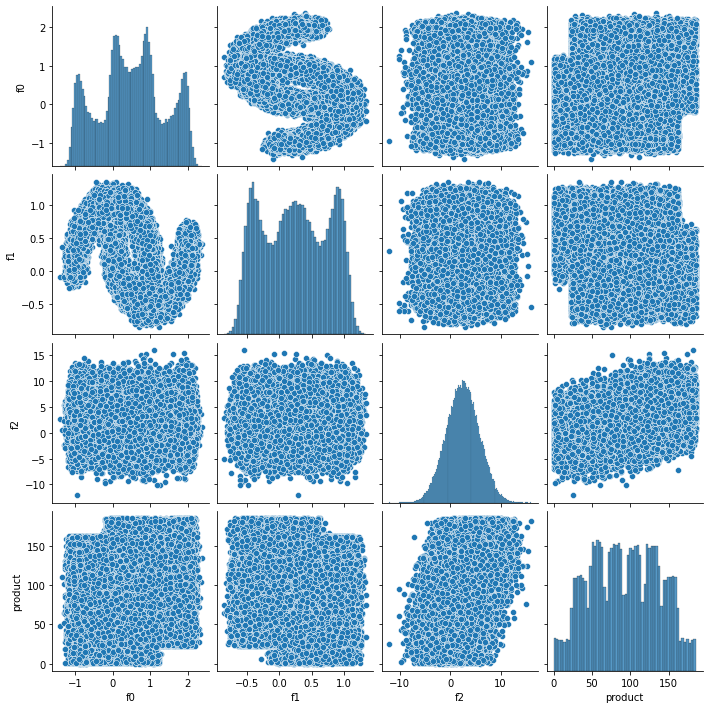

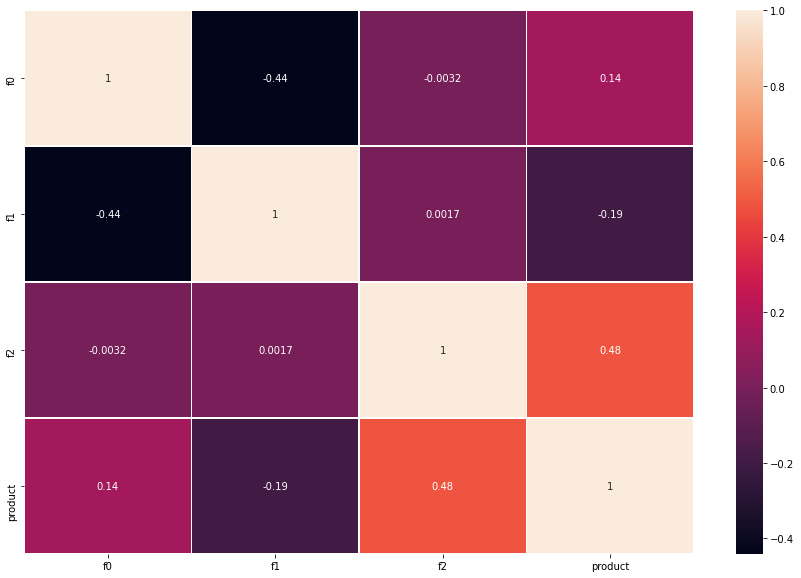

---------------------------------------Изучаем Второй участок---------------------------------------


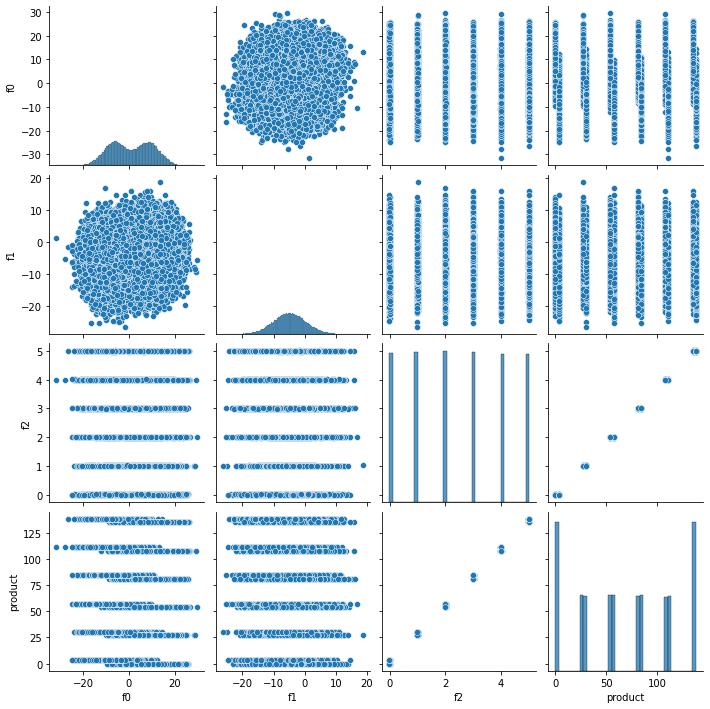

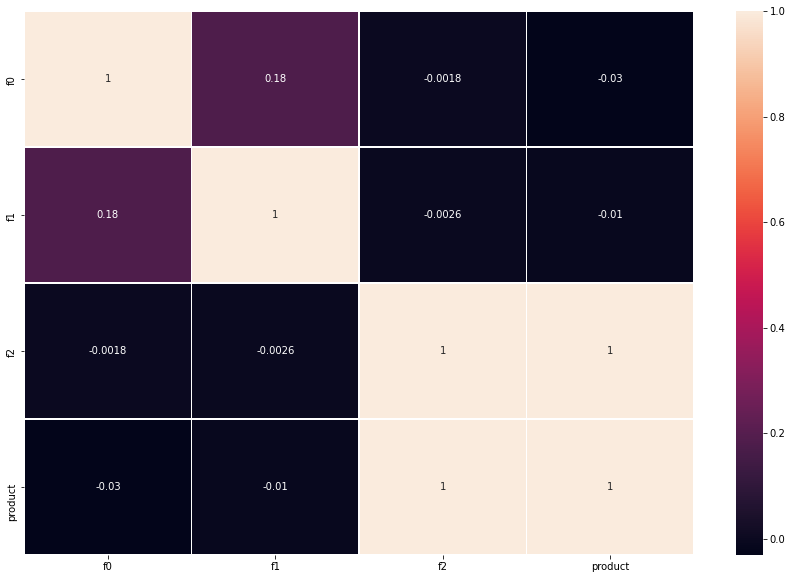

---------------------------------------Изучаем Трерий участок---------------------------------------


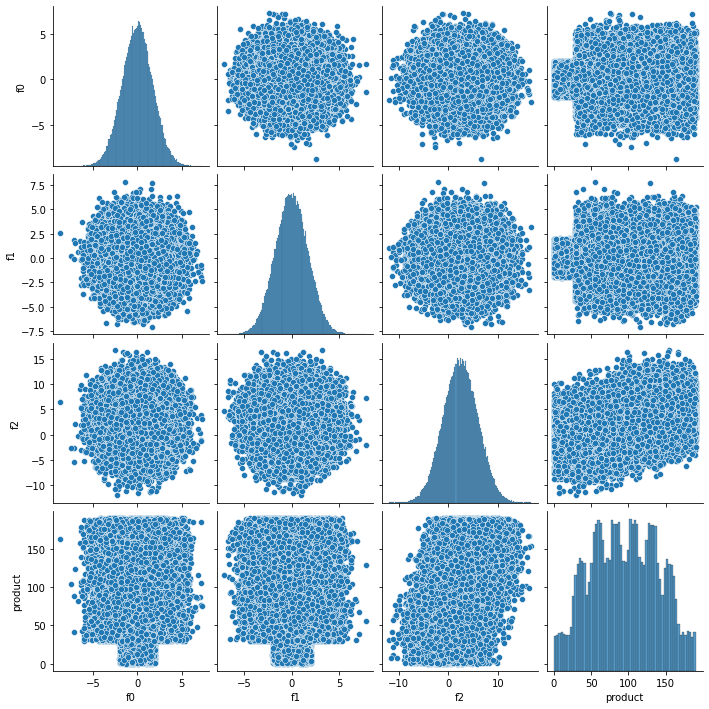

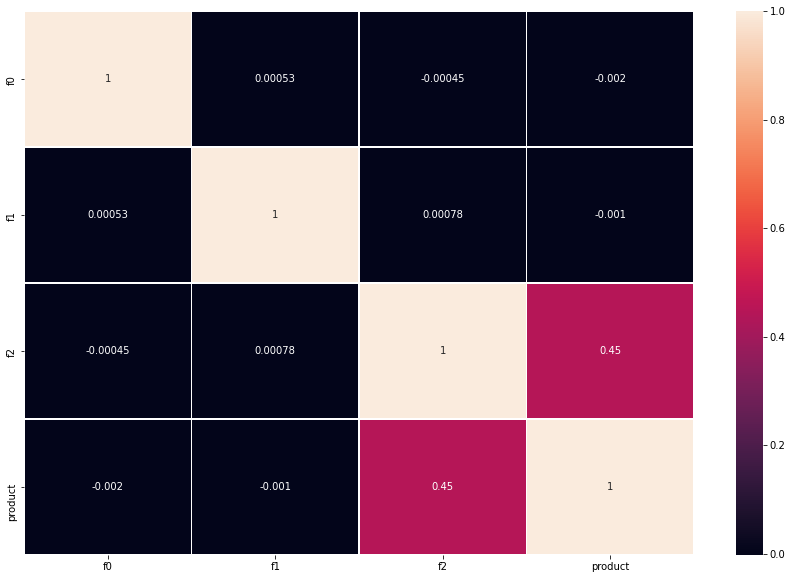

In [12]:
# Дропнем столбец id для всех регионов
for df, name in [(first_region, 'Первый'),
                 (second_region, 'Второй'), 
                 (third_region, 'Трерий')]:
    df.drop('id',axis=1, inplace=True, errors='ignore')
    print(f'Изучаем {name} участок'.center(100, "-"))
    sns.pairplot(df)
    plt.show()
    plt.figure(figsize=(15, 10))
    sns.heatmap(df.corr(), annot=True, linewidths=.5)
    plt.show()

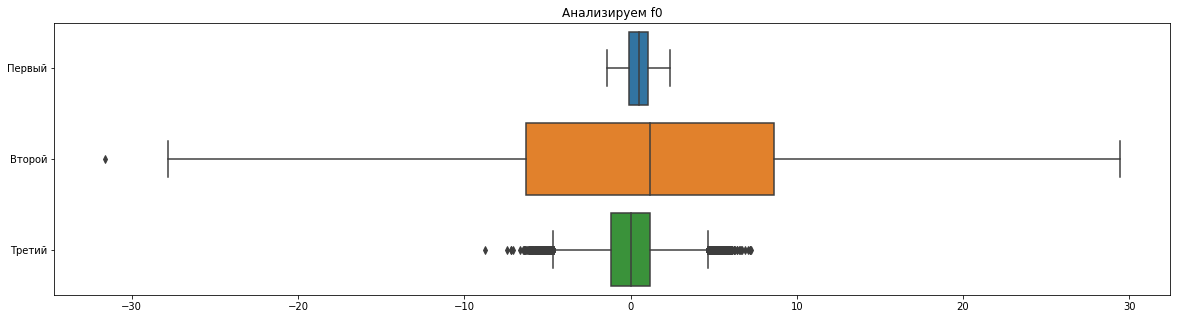

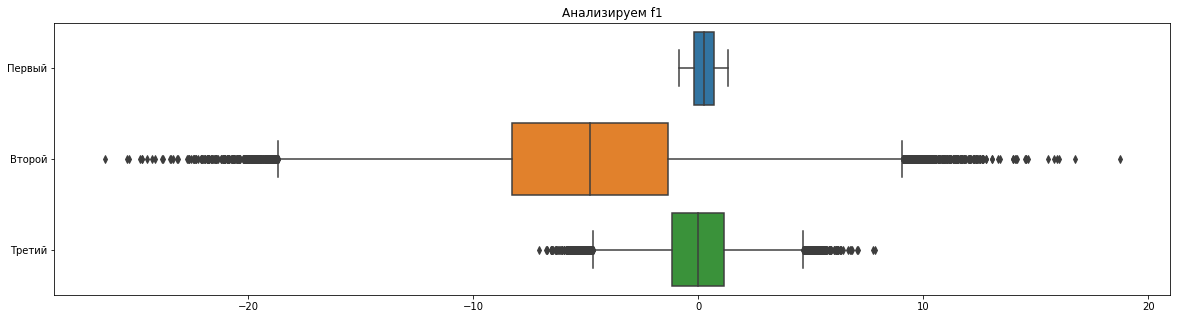

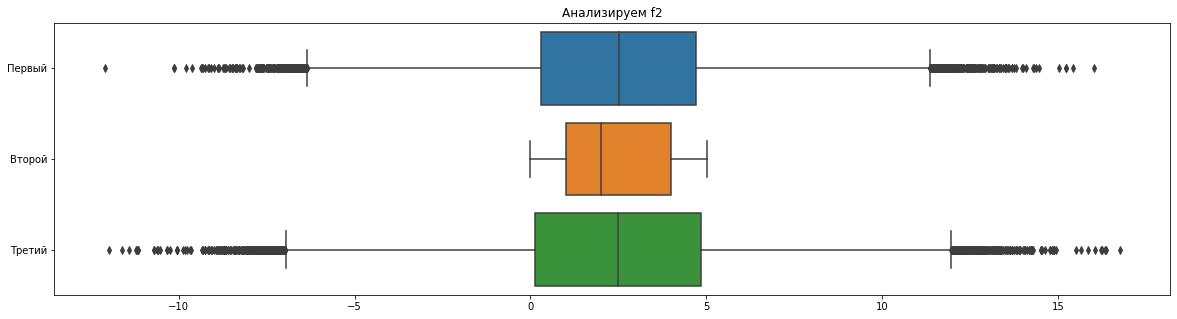

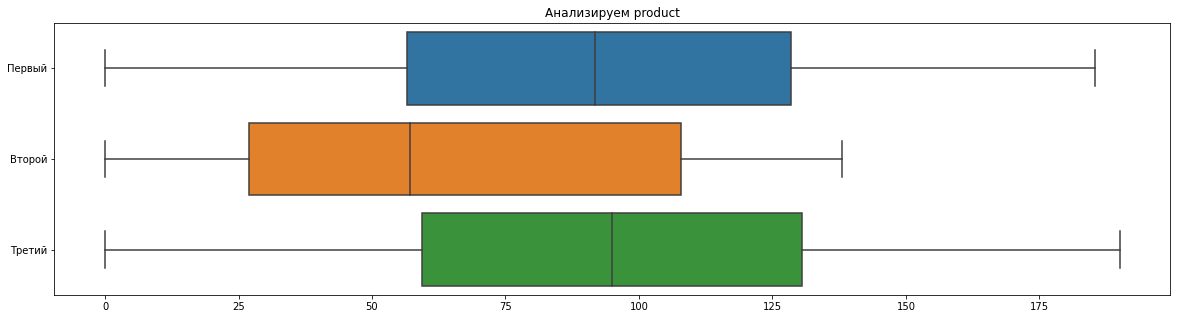

In [13]:
for column in first_region.columns:
    analize = pd.DataFrame({
        'Первый': first_region[column],
        'Второй': second_region[column],
        'Третий': third_region[column]
    })
    plt.figure(figsize=(20, 5))
    sns.boxplot(data=analize, orient='h')
    plt.title(f'Анализируем {column}')
    plt.show()

<a name="1.1."></a>
## Вывод:
В данных по всем 3 регионам пропусков не обнаружено, для хранения всех признаков используются значения c плавающей точкой. Так как коллизии в id для разных регионов мало, то спишем что это всё таки разные месторождения и эти ошибки возникают из-за слишком малого значения выделенного для хэш-пространства, следовательно, id не несут никакой информационной нагрузки и их можно отбросить. При анализе статистик для всех регионов видно, что ключевые признаки f0 и f1 для всех регионов сильно варьируются, что видно по mean и std, распределение признака f2 для первого и третьего регионов почти одинаковые, а распределение f2 для второго региона имеет близкое среднее и меньший разброс относительного mean. 
Между параметрами f0,f1,f2 не наблюдается какой-либо корреляциия. Распределение большинства параметров носит нормальный вид, кроме распределения на втором участке, на котором распределение носит равномерный характер для f2 и целевого признака. Для второго региона видна чёткая прямая корреляция между признаком f2 и целевым признаком
<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="2."></a>
# Шаг 2. Обучаем и проверяем модель для каждого региона
<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="2.1."></a>
## Обучаем модель и генерируем прогнозы на валидационной выборке
<br>

<font size="2">([к содержанию](#0.0))</font>

In [14]:
# Объединим всё в один DataFrame
all_regions = pd.concat([first_region,
                         second_region,
                         third_region])
all_regions.reset_index(drop=True, inplace=True)

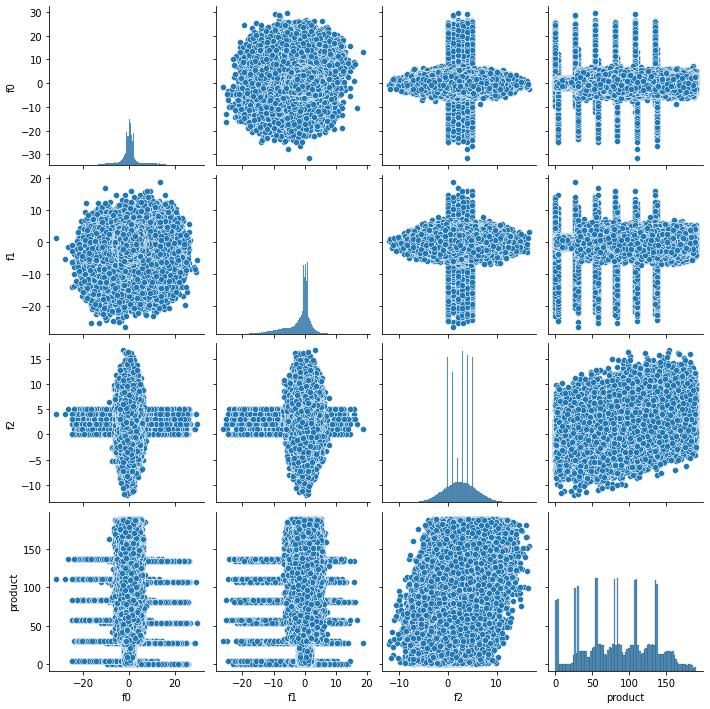

In [15]:
sns.pairplot(all_regions)

In [16]:
def model_education(train, valid, normalization):
    """
    Функция обучения модели
    """
    
    # Выделяем inputs и outputs
    features_train = train.drop('product',axis=1)
    target_train = train['product']
    
    features_valid = valid.drop('product',axis=1)
    target_valid = valid['product']
    
    scaler = None
    # Нормируем при необходимости
    if normalization:
        columns = train.columns
        scaler = StandardScaler()
        features_train = pd.DataFrame(scaler.fit_transform(features_train),
                                      columns=features_train.columns)
        features_valid = pd.DataFrame(scaler.transform(features_valid),
                                      columns=features_train.columns)
    
    # Строим модель и обучаем её
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    # Сохраняем прогнозы
    predicted_values = model.predict(features_valid)
    
    # Вычисляем ошибку на валидационной выборке
    score = mean_squared_error(target_valid, predicted_values)
    
    return scaler, model, np.sqrt(score), predicted_values, target_valid

In [17]:
def find_rmse(data, normalization):
    if isinstance(data, list):
        # Под возвращение
        scalers = []
        models = []
        scores = []
        predictions = []
        target_valids = []
        # У нас на входе в функцию был список из 3 моделей
        for df in data:
            # Делим данные на тренировочные и валидационные
            train, valid = train_test_split(df,
                                            train_size=0.75,
                                            random_state=0,
                                            shuffle=True)
            # Обучаем модель
            scaler, model, score, prediction, target_valid=model_education(train,
                                                                           valid,
                                                                           normalization)
            # Сохраняем результаты
            scalers.append(scaler)
            models.append(model)
            scores.append(score)
            predictions.append(prediction)
            target_valids.append(target_valid)
        return scalers, models, scores, predictions, target_valids
    # В противном случае для обучения передана только 1 модель данных
    else:
        # Делим данные на тренировочные и валидационные
        train, valid = train_test_split(data,
                                        train_size=0.75,
                                        random_state=0,
                                        shuffle=True)
        # Обучаем модель 
        return model_education(train, valid, normalization)

In [18]:
# Под статистику
education_stat = pd.DataFrame(columns=['normalization', 
                                       'RMSE_1','RMSE_2','RMSE_3', 
                                       'model_1', 'model_2', 'model_3',
                                       'scaler_1', 'scaler_2', 'scaler_3'])

predictions_list = []
target_valid_list = []

for normalization in [False, True]:
    # На общем DataFrame
    scaler, model, score, prediction, target_valid = find_rmse(all_regions,
                                                               normalization)
    education_stat.loc[len(education_stat)] = pd.Series([normalization, 
                                                         score,score,score,
                                                         model,model,model,
                                                         scaler,scaler,scaler],
                                                        index=education_stat.columns)
    predictions_list.append({1: prediction, 2: prediction, 3: prediction})
    target_valid_list.append({1: prediction, 2: prediction, 3: prediction})
    # На каждом отдельном
    scalers, models, scores, predictions, target_valids = find_rmse([first_region,
                                                                     second_region,
                                                                     third_region],
                                                                    normalization)
    
    row_number = len(education_stat)
    education_stat.loc[row_number] = pd.Series([normalization,
                                                None, None, None,
                                                None, None, None,
                                                None, None, None],
                                               index=education_stat.columns)
    
    predictions_list.append({})
    target_valid_list.append({})
    
    for i in range(len(scalers)):
        education_stat.loc[row_number,'RMSE_{}'.format(i+1)]=scores[i]
        education_stat.loc[row_number,'model_{}'.format(i+1)]=models[i]
        education_stat.loc[row_number,'scaler_{}'.format(i+1)]=scalers[i]
        predictions_list[len(predictions_list)-1][i+1]=predictions[i]
        target_valid_list[len(target_valid_list)-1][i+1]=target_valids[i]
    
education_stat

,normalization,RMSE_1,RMSE_2,RMSE_3,model_1,model_2,model_3,scaler_1,scaler_2,scaler_3
0,False,38.706659,38.706659,38.706659,LinearRegression(),LinearRegression(),LinearRegression(),None,None,None
1,False,37.481009,0.887257,40.312907,LinearRegression(),LinearRegression(),LinearRegression(),None,None,None
2,True,38.706659,38.706659,38.706659,LinearRegression(),LinearRegression(),LinearRegression(),StandardScaler(),StandardScaler(),StandardScaler()
3,True,37.481009,0.887257,40.312907,LinearRegression(),LinearRegression(),LinearRegression(),StandardScaler(),StandardScaler(),StandardScaler()


In [19]:
predict = predictions_list[1]
actual = target_valid_list[1]
rmse = education_stat.iloc[1, 1:4]

<a name="2.2."></a>
## Вычисляем средний запас сырья и RMSE
<br>

<font size="2">([к содержанию](#0.0))</font>

Регион №1
Средний запас предсказанного сырья: 92.27 тыс. баррелей
RMSE: 37.48100896950594



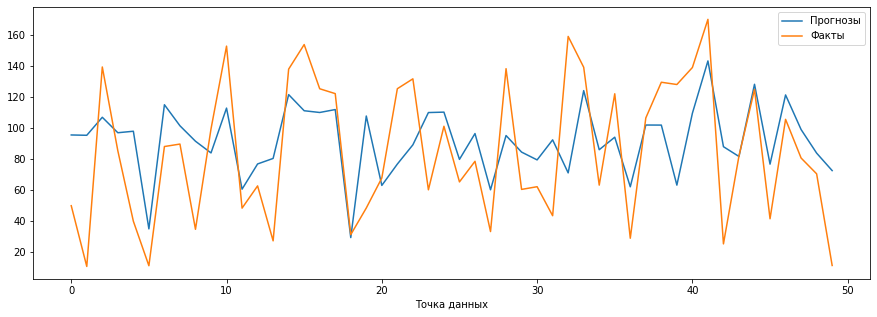

Регион №2
Средний запас предсказанного сырья: 69.15 тыс. баррелей
RMSE: 0.8872573052219325



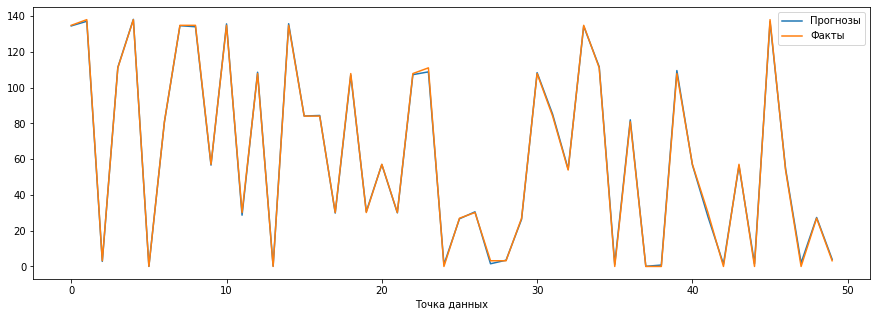

Регион №3
Средний запас предсказанного сырья: 94.71 тыс. баррелей
RMSE: 40.31290686044374



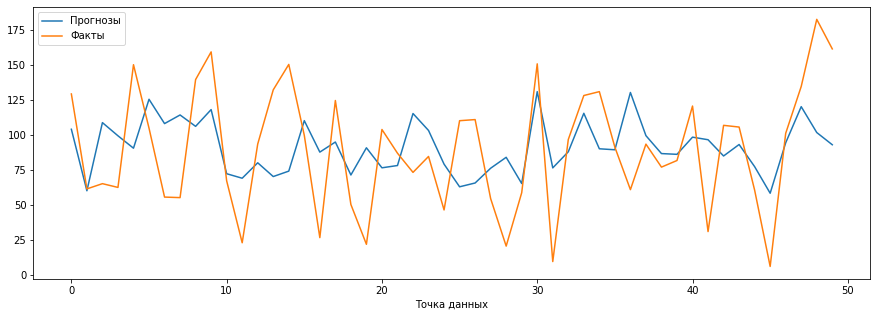

In [20]:
lenth=50
for number in predict.keys():
    print('Регион №{}'.format(number))
    print('Средний запас предсказанного сырья: {:.2f} тыс. баррелей'.format(predict[number].mean()))
    print('RMSE:', rmse[number - 1], end='\n\n')
    
    plt.figure(figsize=(15,5))
    plt.plot(predict[number][:lenth],label='Прогнозы')
    plt.plot(list(actual[number][:lenth]),label='Факты')
    plt.legend()
    plt.xlabel('Точка данных')
    plt.show()

<a name="2.3."></a>
## Вывод:
Обучение осуществляется двумя метода: в первом случае мы строим 3 модели для каждой из областей, во втором мы строим одну модель. Так же для поиска наилучшего набора весов мы будем подавать на вход модели нормированные и не нормированные признаки. Как видно из результатов, нормировка признаков не даёт никакого результата, следовательно, нормировку значений в данном случае можно не проводить. Анализируя значения RMSE, видно, что максимальное RMSE при обучении трёх моделей ниже, чем RMSE для одной общей модели, следовательно, для расчётов использовались три модели без нормировки. Наиболее точные прогнозы получаются для 2 региона, где RMSE почте на 200% меньше, чем в других.
<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="3."></a>
# Шаг 3. Подготовка к расчёту прибыли
<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="3.1."></a>
## Сохраняем ключевые значения в константы
<br>

<font size="2">([к содержанию](#0.0))</font>

In [21]:
budget = 10_000_000_000 # Бюджет на разработку скважин в одном регионе
research_amount = 500   # Количество точек при разведке региона
best_amount = 200       # Количество лучших точек для расчёта прибыли
revenue_per_thousand_barrel = 450_000 # Доход с 1000 барелей
max_risk = 0.025 # Максимальный риск
cost_hole = budget / best_amount # Стоимость разработки одной скважины

<a name="3.2."></a>
## Рассчитываем точку безубыточности разработки новой скважины
<br>

<font size="2">([к содержанию](#0.0))</font>

In [22]:
break_even_volume = budget / revenue_per_thousand_barrel / best_amount
print('Достаточный объём сырья в скважине: {:.6f} тыс. баррелей'.format(break_even_volume))

Достаточный объём сырья в скважине: 111.111111 тыс. баррелей


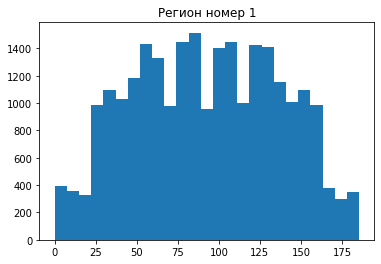

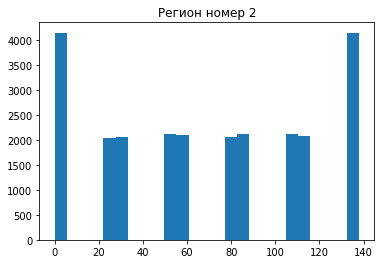

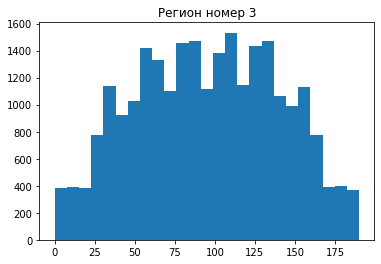

In [23]:
for i in actual:
    plt.title('Регион номер {}'.format(i))
    plt.hist(actual[i], bins=25)
    plt.show()

<a name="3.3."></a>
## Вывод:
Исходя из того, что средний прогнозируемый объём скважен для каждого из регионов соответственно равен 92.27, 69.15, 94.71 тыс. баррелей, а безубыточный объём начинается с 111 тыс. баррелей, то брать случайные скважины нельзя, так так есть риск не получить чистую прибыль больше 0
<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="4."></a>
# Шаг 4. Расчёт прибыли и рисков
<br>

<font size="2">([к содержанию](#0.0))</font>

In [24]:
def calculate_net_profit(actual_sample, predicted_sample, best_amount):
    # Сортируем прогнозы
    predicted_sorted = predicted_sample.sort_values(ascending=False)
    # Проссумируем наши фактические значения объёма и найдём выручку с региона
    revenue = (actual_sample.loc[predicted_sorted.index][:best_amount].sum() *
               revenue_per_thousand_barrel)
    # Валовая прибыль=оборот-себестоимость (стоимость скважины)
    gross_profit = revenue - cost_hole * best_amount
    # Чистая прибыль=Валовая прибыль - 20%*Валовая прибыль
    return 0.8 * gross_profit

state = np.random.RandomState(12345)
bootstrap  =1000

for region in predict:
    net_profit_list = []
    # Объединим наши данные, чтобы удобнее было работать
    dataset = pd.DataFrame({'Прогнозы': predict[region],
                            'Факты': actual[region]})

    for i in range(bootstrap):
        # Выбираем 500 значений без разрешения повторного выбора
        predicted_sample = dataset['Прогнозы'].sample(n=research_amount,
                                                      replace=False,
                                                      random_state=state)
        actual_sample = dataset.loc[predicted_sample.index, 'Факты']
        # Вычисляем чистую прибыль
        net_profit_list.append(calculate_net_profit(actual_sample,
                                                    predicted_sample,
                                                    best_amount))
    
    net_profit_series = pd.Series(net_profit_list)
    
    loss_probability = (len(net_profit_series[net_profit_series < 0]) /
                        len(net_profit_series))
    
    print('Средняя прибыль для {} региона: {:.0f}'.format(region,
                                                          net_profit_series.mean()))
    print('2.5%-квантиль: {:.0f}'.format(net_profit_series.quantile(0.025)))
    print('97.5%-квантиль: {:.0f}'.format(net_profit_series.quantile(0.975)))
    print('Вероятность убытков: {:%}'.format(loss_probability))
    
    print('='*20)

Средняя прибыль для 1 региона: 358055049
2.5%-квантиль: -31792952
97.5%-квантиль: 774942670
Вероятность убытков: 3.400000%
Средняя прибыль для 2 региона: 379000430
2.5%-квантиль: 69201770
97.5%-квантиль: 706497529
Вероятность убытков: 1.000000%
Средняя прибыль для 3 региона: 316363374
2.5%-квантиль: -84967089
97.5%-квантиль: 704420871
Вероятность убытков: 6.600000%


<a name="5."></a>
# Шаг 5. Общие выводы

Чистая прибыль колеблется в диапазоне от 316 до 379 для всех 3 регионов. Но исходя из условия задачи, что вероятность убытков не должна быть больше 2.5% единственный регион, подходящий под проект, является второй, который показал как минимальное RMSE на этапе обучения модели, так и наилучший доверительный интервал распределения прибыли, полученное с помощью методики Bootstrap(нижнее значение интервала положительное). К тому же данный регион показывает максимальное значение средней прибыли
<br>

<font size="2">([к содержанию](#0.0))</font>